In [1]:
%env JAX_CHECK_TRACER_LEAKS = True

env: JAX_CHECK_TRACER_LEAKS=True


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import treescope as ts
import matplotlib.pyplot as plt
from typing import Callable, NamedTuple
from jaxtyping import Array, Float, Int, Key
from flax import nnx
import numpy as np
import optax
from tqdm import tqdm
import pickle

rngs = nnx.Rngs(0)

In [3]:
class Cifar10(nnx.Module):
    def __init__(self, path="cifar10/", *, rngs):
        self.rngs = rngs
        data, labels = [], []
        for i in range(6):
            with open(path + f"data_batch_{i+1}", "rb") as fo:
                batch = pickle.load(fo, encoding="bytes")
                data.append(batch[b"data"])
                labels.append(batch[b"labels"])
        data = np.concatenate(data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.concatenate(labels)
        self.labels = nnx.Param(jnp.array(labels))
        self.data = nnx.Param(jnp.array(data)/255)
        self.label_names = [
            "plane", "car", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]

    def plot_examples(self):
        X, Y = self.sample(40)
        plt.figure(figsize=(10, 4))
        for i, (img, label) in enumerate(zip(X, Y)):
            plt.subplot(4, 10, i + 1)
            plt.imshow(img)
            plt.title(self.label_names[label])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    def sample(self, n: int) -> tuple[Float[Array, "n 32 32 3"], Int[Array, "n"]]:
        idx = jr.choice(self.rngs(), len(self.data), (n,))
        return self.data[idx], self.labels[idx]

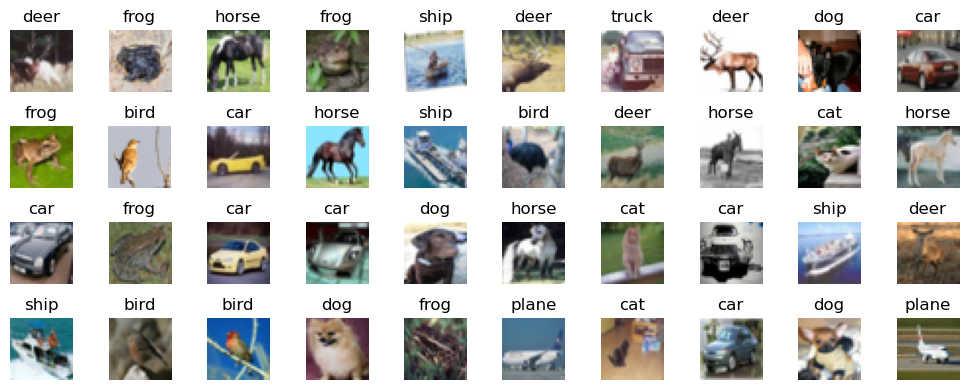

In [4]:
dataset = Cifar10(rngs=rngs)
nnx.display(dataset)
dataset.plot_examples()

In [5]:
class FullyConnected(nnx.Sequential):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int, *, rngs):
        super().__init__(
            nnx.Linear(in_dim, hidden_dim, rngs=rngs),
            nnx.silu,
            nnx.Linear(hidden_dim, out_dim, rngs=rngs),
        )


class ConvBetaVAE(nnx.Module):
    def __init__(self, dim: int, channels=3, kernel_size=(3, 3), *, rngs):
        self.rngs = rngs
        self.encoder = nnx.Sequential(
            nnx.Conv(channels, dim, kernel_size, rngs=rngs),
            jnp.sin,
            nnx.Conv(dim, 2 * dim, kernel_size, rngs=rngs),
        )
        self.decoder = nnx.Sequential(
            nnx.Conv(dim, dim, kernel_size, rngs=rngs),
            jnp.sin,
            nnx.Conv(dim, channels, kernel_size, rngs=rngs),
        )

    def encode(self, img: Float[Array, "... H W C"]) -> Float[Array, "... H W C"]:
        mu, std = jnp.split(self.encoder(img), 2, axis=-1)
        return mu

    def decode(self, img: Float[Array, "... H W C"]) -> Float[Array, "... H W C"]:
        return jax.nn.sigmoid(self.decoder(img))

    def loss(self, img: Float[Array, "... H W C"], beta=1.0):
        mu, std = jnp.split(self.encoder(img), 2, axis=-1)
        z = mu + std * jr.normal(self.rngs(), mu.shape)
        kl = std**2 + mu**2 - jnp.log(std**2) - 1
        return jnp.mean((img - self.decode(z)) ** 2) + 0.5 * beta * jnp.mean(kl)


class ImageTokenizer(nnx.Module):
    def __init__(self, dim: int, channels=3, size=2, *, rngs):
        self.patch_encoder = FullyConnected(channels * size**2, dim, dim, rngs=rngs)
        self.patch_decoder = FullyConnected(dim, dim, channels * size**2, rngs=rngs)
        self.size = size

    def encode(self, img: Float[Array, "... H W C"]) -> Float[Array, "... N D"]:
        *B, H, W, C = img.shape
        patch_shape = (*B, H // self.size, self.size, W // self.size, self.size, C)
        patches = jnp.reshape(img, patch_shape)
        patches = patches.swapaxes(-4, -3).reshape(*B, -1, C * self.size**2)
        tokens = self.patch_encoder(patches)
        return tokens / jnp.linalg.norm(tokens, axis=-1, keepdims=True)

    def decode(
        self, tokens: Float[Array, "... N D"], img_shape
    ) -> Float[Array, "... H W C"]:
        *B, H, W, C = img_shape
        patch_shape = (*B, H // self.size, W // self.size, self.size, self.size, C)
        patches = self.patch_decoder(tokens)
        img = patches.reshape(patch_shape).swapaxes(-4, -3).reshape((*B, H, W, C))
        return jax.nn.sigmoid(img)

In [6]:
tokenizer = ImageTokenizer(16, rngs=rngs)
autoencoder = ConvBetaVAE(16, rngs=rngs)

x = dataset.sample(10)[0]
y = autoencoder.encode(x)
z = autoencoder.decode(y)
print(x.shape, y.shape, z.shape)

(10, 32, 32, 3) (10, 32, 32, 16) (10, 32, 32, 3)


In [13]:
nnx.display(tokenizer, autoencoder)

optimizer = nnx.Optimizer(autoencoder, optax.adam(1e-4))

@nnx.jit
def train_step(optimizer, data):
    @nnx.value_and_grad
    def loss_fn(model):
        imgs, _ = data.sample(32)
        return model.loss(imgs, beta=1.0)

    loss, grads = loss_fn(optimizer.model)
    optimizer.update(grads)
    return loss


for _ in (pbar := tqdm(range(1000))):
    loss = train_step(optimizer, dataset)
    pbar.set_postfix(loss=loss)

100%|██████████| 1000/1000 [02:05<00:00,  7.99it/s, loss=0.029657895]


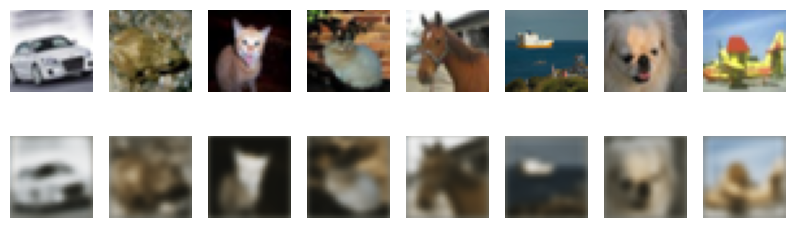

In [14]:
imgs, _ = dataset.sample(8)
recon = autoencoder.decode(autoencoder.encode(imgs))
plt.figure(figsize=(10, 3))
for i, (img, rec) in enumerate(zip(imgs, recon)):
    plt.subplot(2, 8, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(2, 8, i + 9)
    plt.imshow(rec)
    plt.axis("off")

In [9]:


class TimeEmbed(nnx.Module):
    def __init__(self, dim: int, expand=1, max_period=10, *, rngs):
        log_freqs = -jnp.log(max_period) * jnp.arange(dim // 2) / (dim // 2)
        self.freqs = nnx.Param(jnp.exp(log_freqs))
        self.fc = FullyConnected(dim, expand * dim, dim, rngs=rngs)

    def __call__(self, t: Float[Array, "..."]) -> Float[Array, "... D"]:
        x = t[..., None] * self.freqs
        x = jnp.concat([jnp.sin(x), jnp.cos(x)], axis=-1)
        return self.fc(x)



class MultiheadAttention(nnx.Module):
    def __init__(self, dim: int, heads: int, use_bias=False, *, rngs):
        self.proj = nnx.LinearGeneral(
            dim, (heads, dim // heads * 3), use_bias=use_bias, rngs=rngs
        )

    def __call__(self, x: Float[Array, "... N D"]) -> Float[Array, "... N D"]:
        q, k, v = jnp.split(self.proj(x), 3, axis=-1)
        w = jnp.einsum("...shd,...Shd->...hsS", q, k)
        w = jax.nn.softmax(w / q.shape[-1], axis=-1)
        res = jnp.einsum("...hsS,...Shd->...shd", w, v)
        return res.reshape(x.shape)


class Block(nnx.Module):
    def __init__(self, dim: int, heads: int, expand: int, *, rngs):
        self.norm1 = nnx.RMSNorm(dim, rngs=rngs)
        self.attention = MultiheadAttention(dim, heads, rngs=rngs)
        self.norm2 = nnx.RMSNorm(dim, rngs=rngs)
        self.fc = FullyConnected(dim, dim * expand, dim, rngs=rngs)

    def __call__(self, x: Float[Array, "... N D"]) -> Float[Array, "... N D"]:
        x = x + self.attention(self.norm1(x))
        x = x + self.fc(self.norm1(x))
        return x


class Transformer(nnx.Module):
    def __init__(self, dim: int, depth: int, heads: int, img_channels=3, patch_size=2, expand: int = 2, *, rngs):
        self.time_embed = TimeEmbed(dim, expand, rngs=rngs)
        self.pos_embed = TimeEmbed(dim, expand, rngs=rngs)
        self.tokenizer = ImageTokenizer(dim, rngs=rngs)
        self.blocks = [Block(dim, heads, expand, rngs=rngs) for _ in range(depth)]

    def __call__(
        self, img: Float[Array, "... seq voc"], t: Float[Array, "... 1"]
    ) -> Float[Array, "... seq voc"]:
        pos = jnp.arange(x.shape[-2]) / x.shape[-2]
        c = self.pos_embed(pos) + self.time_embed(t)
        print(c.shape)
        x = self.tokenizer.encode(x)
        print(x.shape)
        for block in self.blocks:
            x = block(x + c)
        return self.tokenizer.decode(x,

SyntaxError: incomplete input (222439326.py, line 58)

In [8]:
SEQ_LEN = 1

data = Dataset("data.txt", rngs=rngs)
model = Transformer(vocab=data.vocab_size, dim=64, depth=8, heads=4, rngs=data.rngs)
optimizer = nnx.Optimizer(model, optax.adamw(1e-3))
nnx.display(model)

AttributeError: 'Dataset' object has no attribute 'vocab_size'

In [ ]:

def flow_train_sample(data, batch_size):
    t = jr.uniform(data.rngs(), (batch_size, 1,))
    x0 = jr.randint(data.rngs(), (batch_size, SEQ_LEN,), 0, data.vocab_size)
    x0 = jax.nn.one_hot(x0, data.vocab_size)
    x1 = data.sample(batch_size, SEQ_LEN)

    xt = (1 - t[..., None]) * x0 + t[..., None] * x1
    xt = xt + jr.normal(data.rngs(), xt.shape) * 0.01
    dx = x1 - x0
    return t, xt, dx, x0, x1


@nnx.jit
def step(optimizer, data):
    def loss_fn(model):
        t, x, dx, x0, x1 = flow_train_sample(data, batch_size=1024)
        return optax.l2_loss(model(x, t), dx).mean()

    loss, grad = nnx.value_and_grad(loss_fn)(optimizer.model)
    optimizer.update(grad)
    return loss

In [34]:
for _ in (pbar:=tqdm(range(100))):
    loss = step(optimizer, data)
    pbar.set_postfix({"loss": loss})

100%|██████████| 100/100 [00:34<00:00,  2.88it/s, loss=0.0069745863]


In [35]:
def push(data, model, samples=8, n_steps=16):
    def runje_kutta_step(x, t):
        k1 = model(x, t)
        k2 = model(x + k1 * dt / 2, t + dt / 2)
        k3 = model(x + k2 * dt / 2, t + dt / 2)
        k4 = model(x + k3 * dt, t + dt)
        next_x = x + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
        return next_x, x

    t, x, dx, x0, x1 = flow_train_sample(data, batch_size=samples)
    dt = 1 / n_steps
    ts = dt * jnp.arange(n_steps)[..., None, None]
    x1, xt = jax.lax.scan(runje_kutta_step, x0, ts)
    return x1
    

for x1 in push(data, model):
    print("---------------------------------")
    print(data.decode(x1))

---------------------------------
N
---------------------------------
*
---------------------------------
[
---------------------------------

---------------------------------
<
---------------------------------

---------------------------------
2
---------------------------------
9


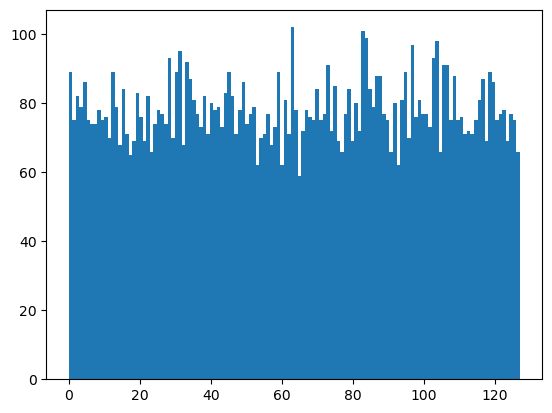

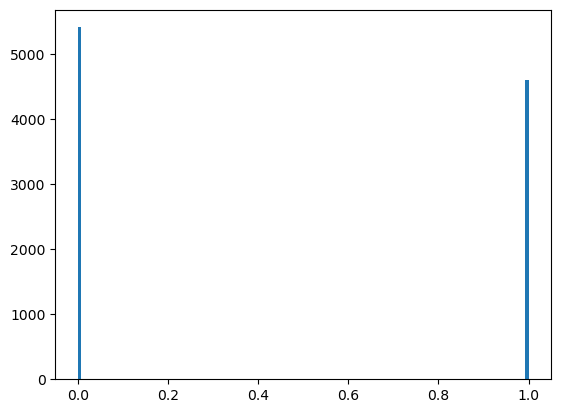

In [36]:
y = push(data, model, samples=10000)
plt.hist(y.argmax(-1).flatten(), bins=128);
plt.show()
*_, y = flow_train_sample(data, batch_size=10000)
plt.hist(y.argmax(-1).flatten(), bins=128);